# Global definitions

Load Pylab, define CPTs...

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Define the CPTs

In [2]:
L = array([0.9, 0.1])

B = array([0.99, 0.01])

P_L = array([[0.8, 0.1], 
             [0.2, 0.9]])

T_P = array([[0.8, 0.1], 
             [0.2, 0.9]])

O_PB = array ([[[0.01, 0.7],
                [0.8, 0.999]],
               [[0.99, 0.3],
               [0.2, 0.001]]])

P = (P_L * L).sum(1)
T = (T_P * P).sum(1)

In [44]:
# Define the CPTs and other useful functions here (e.g. samling from a distribution) here...

def sampleL_TO(n):
    samples = []
    for i in range(0, n):
        samples.append([random.random(), random.randint(0, 2), random.randint(0, 2)])
    return np.asmatrix(samples)
        
def sample(n):
    return random.sample(n)

# 1) Approximate Inference Algorithms

Approximate $P(E\mid M, S)$ using various techniques.

## A) Rejection Sampling

In [45]:
def approx_rs(t, o, n):
    
    """ 
    Approximates P(L | T, O) using rejection sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    
    """
    First generate the random samples for the events
    An array of triples was used for taking into consideration only the variables that are of interested for the given problem
    """
    L_TO = sampleL_TO(n)
    """
    Discover how many events fulfill the conditions t and o (the evidence)
    If there are events that fulfill the evidence, check how many of them verify L = l 
    If no event fulfills the evidence repeat sampling procedure
    """
  
    consistentEv = L_TO[(L_TO[:,1] == t) & (L_TO[:,2] == o)][0,:]
    pos_samples = array(consistentEv[consistentEv > L[0]]).size
    rs_approx_L_TO = array([1 - double(pos_samples)/consistentEv.size, double(pos_samples)/consistentEv.size])
    return rs_approx_L_TO
    
approx_rs(1, 0, 1000)

array([ 0.88492063,  0.11507937])

## B) Likelihood Weighting

In [46]:
global valid_weight
global total_weight
def approx_lw(t, o, n):
    """
    Empty implementation of Aiv)
    Approximates P(L | T, O) using likelihood weighting
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    valid_weight = 0
    total_weight = 0
    """
    Chosen topological ordering: L, P, B O, T
    """
    
    """
    Sample L, P, B
    """
    s_L = sample(n)
    s_P = sample(n) 
    s_B = sample(n)
    """
    O and T are given as evidence
    """
    for i in range (0, n):
        weight = 1
        l_pos = int(s_L[i]>L[0])
        if (s_P[i]>P_L[0, l_pos]):                # P has the value 1  
            weight *= T_P[t, 1]
            if (s_B[i]>B[0]):                     # B has the value 1
                weight *= O_PB[o, 1, 1]
            else:                                 # B has the value 0
                weight *= O_PB[o, 1, 0]
        else:                                     # P has the value 0
            weight *= T_P[t, 0]
            if (s_B[i]>B[0]):                     # B has the value 1
                weight *= O_PB[o, 0, 1]
            else:
                weight *= O_PB[o, 0, 0]           # B has the value 0
        if (l_pos == 1) :
            valid_weight += weight
 
        total_weight += weight
    lw_approx_L_TO = [1-double(valid_weight)/total_weight, double(valid_weight)/total_weight]
    return lw_approx_L_TO

approx_lw(1, 0, 1000)

[0.69675781138665704, 0.30324218861334301]

## C) Gibbs Sampling

In [47]:
def approx_gibbs(t, o, n):
    
    """ 
    Approximates P(L | T, O) using Gibbs sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    
    """
    Chosen topological ordering: L, P, B O, T
    """
    """
    Sample L, P, B
    """
    s_L = sample(1)
    s_P = sample(1) 
    s_B = sample(1)
    
    l_pos = int (s_L[0] > L[0])
    p_pos = int (s_P[0] > P[0])
    b_pos = int (s_P[0] > P[0])
    """
    O and T are given as evidence
    """
    
    valid_ex = 0 
    for i in range (0, n):
        
        # Resample L according to new distribution
        nl_gibbs = L[0] * P_L[p_pos, 0]
        l_gibbs = L[1] * P_L[p_pos, 1]
        l_sum = nl_gibbs + l_gibbs
        l_gibbs = array([double(nl_gibbs)/l_sum, l_gibbs/l_sum])
        l_val = random.sample(1)
        l_pos = int (l_val > l_gibbs[0]) 
        # Resample P according to new distribution  
        np_gibbs = P_L[0, l_pos] * T_P[t, 0] * O_PB[o, 0, b_pos]
        p_gibbs = P_L[1, l_pos] * T_P[t, 1] * O_PB[o, 1, b_pos]
        p_sum = np_gibbs + p_gibbs
        p_gibbs = array([np_gibbs/p_sum, p_gibbs/p_sum])
        p_val = random.sample(1)
        p_pos = int (p_val > p_gibbs[0]) 
        # Resample P according to new distribution 
        nb_gibbs = B[0] * O_PB[o, p_pos, 0]
        b_gibbs = B[1] * O_PB[o, p_pos, 1]
        b_sum = nb_gibbs + b_gibbs
        b_gibbs = array([nb_gibbs/b_sum, b_gibbs/b_sum])
        b_val = random.sample(1)
        b_pos = int (b_val > b_gibbs[0]) 
        if l_pos == 1:
            valid_ex += 1      
        
    gibbs_approx_L_TO = array([1-double(valid_ex)/n, double(valid_ex)/n])
   
    return gibbs_approx_L_TO
approx_gibbs (1, 0, 1000)

array([ 0.673,  0.327])

# 2) Comparison

## A) Exact Inference

In [48]:
def exact(t, o):
    """ 
    Computes P(L | T, O) using exact inference
    :param t: given value for T
    :param o: given value for O
    :returns: Numpy array containing the distribution
    """    
    L_OT = L[1] * (P_L[0, 1] * T_P[t, 0] * B[0] * O_PB[o, 0, 0] + # p = 0, b = 0 
                 + P_L[0, 1] * T_P[t, 0] * B[1] * O_PB[o, 0, 1] + # p = 0, b = 1
                 + P_L[1, 1] * T_P[t, 1] * B[0] * O_PB[o, 1, 0] + # p = 1, b = 0 
                 + P_L[1, 1] * T_P[t, 1] * B[1] * O_PB[o, 1, 1]) # p = 1, b = 1
    NL_OT = L[0] *(P_L[0, 0] * T_P[t, 0] * B[0] * O_PB[o, 0, 0] + # p = 0, b = 0 
                 + P_L[0, 0] * T_P[t, 0] * B[1] * O_PB[o, 0, 1] + # p = 0, b = 1
                 + P_L[1, 0] * T_P[t, 1] * B[0] * O_PB[o, 1, 0] + # p = 1, b = 0 
                 + P_L[1, 0] * T_P[t, 1] * B[1] * O_PB[o, 1, 1]) # p = 1, b = 1
    
    Lsum = L_OT + NL_OT
    
    return array([double(NL_OT)/Lsum, double(L_OT)/Lsum])
exact(1, 0)

array([ 0.67066293,  0.32933707])

## B) Compute and plot estimation errors

In [49]:
def kld(p, q):
    """
    Computes the Kullback-Leibler divergence between p and q.
    :param p: true distribution
    :param q: estimated distribution
    :return: Kullback-Leibler Divergence between p and q
    """
    return (p * np.log(p / (q + 0.00000000001))).sum()  # add a small constant for numeric stability


def compute_approximation_error(approx_function, t, o, n_runs, sample_counts, **kwargs):
    """
    Computes the approximation error for a given approximation method.
    :param approx_function: function used to approximate the distribution
    :param t: given value for T
    :param o: given value for O
    :param n_runs: number of approximations
    :param sample_counts: list or array of numbers of sampels to use
    :returns: mean approximation error for each of the sample counts
    """
    mean_errors = []
    correct = exact(t, o)
    
    for num_samples in sample_counts:
        estimates = array([approx_function(t, o, n=num_samples, **kwargs) for i in range(n_runs)])
        mean_errors.append(abs(estimates - correct).mean())       
        #mean_errors.append(kld(correct, estimates))  # use this instead of the line above for KLD!
    
    return mean_errors

### Compute the estimation errors


In [53]:
rs_errs = {}
lw_errs = {}
gb_errs = {}
n_runs = 100
sample_counts = array([10, 20, 40, 80, 160, 320, 640, 1280])

for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    rs_errs[(t, o)] = compute_approximation_error(approx_rs, t, o, n_runs, sample_counts)
    lw_errs[(t, o)] = compute_approximation_error(approx_lw, t, o, n_runs, sample_counts)
    gb_errs[(t, o)] = compute_approximation_error(approx_gibbs, t, o, n_runs, sample_counts)

C:\Users\bugaa_000\Anaconda\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars


### Plot the estimation errors

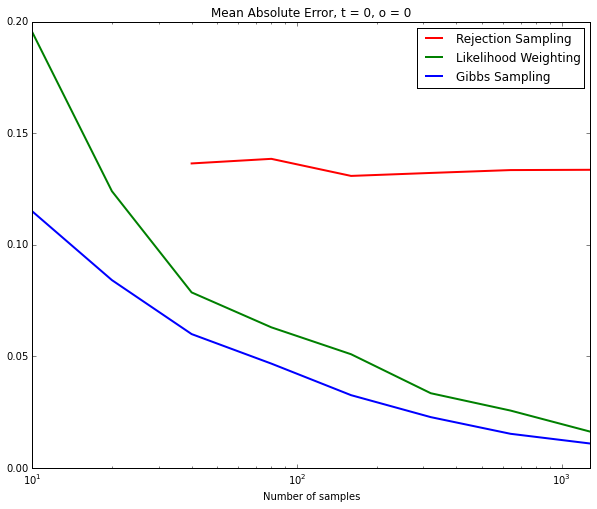

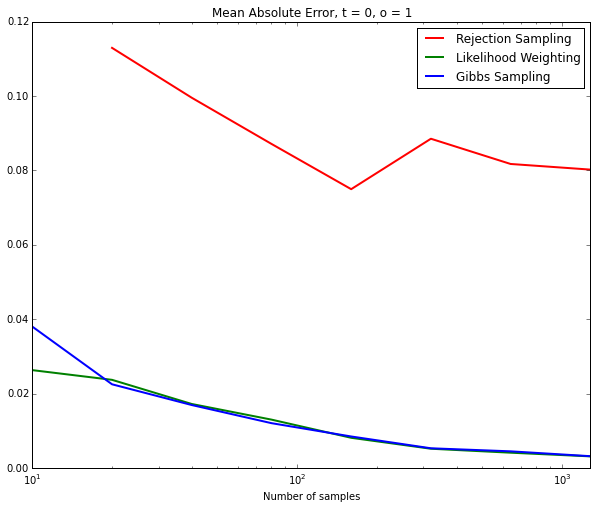

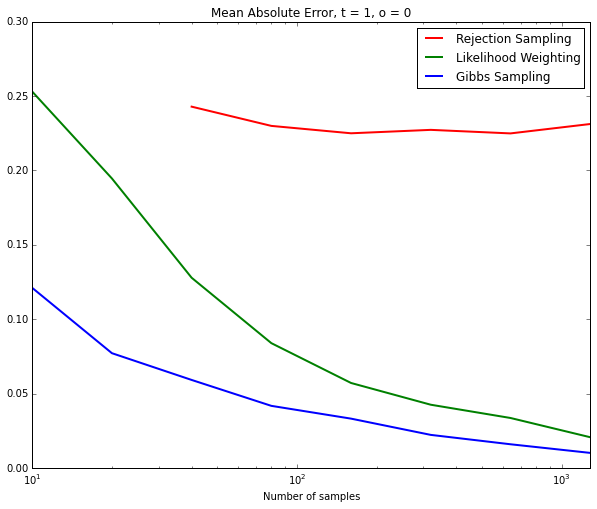

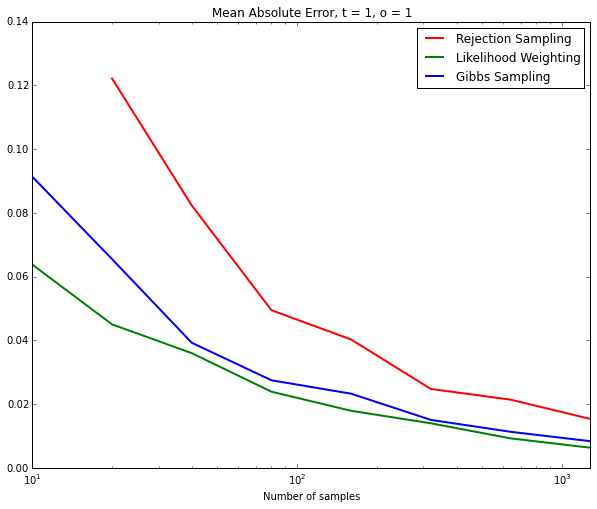

In [54]:
for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    figure(figsize=(10, 8))
    title('Mean Absolute Error, t = %d, o = %d' % (t, o))

    plot(sample_counts, rs_errs[(t, o)], 'r', label='Rejection Sampling', lw=2)
    plot(sample_counts, lw_errs[(t, o)], 'g', label='Likelihood Weighting', lw=2)
    plot(sample_counts, gb_errs[(t, o)], 'b', label='Gibbs Sampling', lw=2)   
    
    legend()
    xscale('log')
    xlim(sample_counts.min(), sample_counts.max())
    xlabel('Number of samples')

## Interpretation of results and comparison of methods

Different values of T and O influence, in fact:
-	the number of samples that conform with the evidence in the case of rejection sampling which can make the method more precise;
-	the weights in case of likelihood weighting which influence the approximation of the method
-	the resampling distribution in case of  gibbs sampling making the method more accurate;

In all cases, the differences are revealed in the convergence speed of the methods.

We can compare the approximation methods by their convergence which in fact reveal the error in their approximation.

For rejection sampling, the higher number of samples the more samples that are not rejected and the better the approximation. A surprise for rejection sampling was the variation for convergence for t = 0, o = 1. In case t = 0, o = 0 and t = 1 and o = 0 the method does not converge. This happens because the number of samples that are rejects is very high, letting the algorithm deal only with few valid samples. 

Likelihood weighting presents better results, as it does not discard any examples.  In our case, the evidence is part of the leaves of the graph which makes many samples nearly irrelevant to given evidence. As presented in theory, likelihood weighting is very when variables are „downstream” in the net, fact that was observed in our case also. The effect of the „downstream” downfall is noticed in the t = 1, o = 0 and t = 0, o = 0.

I was surprised to notice that likelihood weighting exhibited smaller errors than gibbs sampling in some situations (t=1, o=1, for instance).

As expected, Gibbs sampling converged to very good results for all values of T and O. The convergence was faster in case of t=1 and o=0 and this was probably influenced by the resampling probabilities which are affected by values of t and o. As even the evidence of children is used for Gibbs sampling, the method is more accurate and it is closer to the target distribution. 